# Skip-Gram word2vec with Negative Sampling

This notebook presents an exploration of Skip-gram model for learning word embeddings. Skip-gram and CBOW (Continuous Bag of Words) are two types of `word2vec` architectures first introduced in [1]. The latter aims at predicting a target word given its surrounding context words within a context window, while the former does the reverse — predicting surrounding context words given a target word, which is what we will study in this notebook.

In Section 1, we go over the theory of skip-gram model and how they learn vector representations (embeddings) of words in a high dimensional space, and we conclude with preparing the `text8` corpus and generating the training data. In Section 2, we discuss some techniques for approximating expensive, and practically prohibitive, computations. In Section 3, we discuss and implement the shallow neural network that is used for training skip-gram, construct a measure for extrinsic evaluation, and run the training loop. In Section 4, we test the learned word embeddings by i) retrieving similar words using cosine similarities, ii) exploring linear relationships in the embedding space between word analogies, and iii) visualizing the embeddings. To conclude, in Section 5, we train a skip-gram model using `gensim`'s, much faster, C/Cython implementation of skip-gram and compare the performance with our model.

# 1 Introduction to Skip-gram model

In Section 1.1, we discuss the theoretical formulation of the skip-gram model, introducing it as a statistical model, deriving the MLE and ERM problem, and conclude with some training heuristics. In Section 1.2-4, we put the theory and heuristics into practice by setting up the training corpus and generating training data.

## 1.1 A bit of theory

The skip-gram model aims to predict context words based on a center word. For example, consider an excerpt from a corpus like: _"paris is the capital city of france"_. Choosing “capital” as the _center word_ and setting a _context window_ of size 3, we consider words within 3 positions before or after the center word, resulting in the following set of center-context pairs::
- (capital, paris)  
- (capital, is)  
- (capital, the)  
- (capital, city)  
- (capital, of)  
- (capital, france)  

The skip-gram model then learns vector representations (embeddings) for words by maximizing the likelihood of the observed center-context pairs.

**Setup.** We assume any center-context pair $(c,w)$ to be a random variable taking values in $\mathcal{V}\times \mathcal{V}$ where $\mathcal{V}$ is a finite vocabulary of words. A standard choice in the skip-gram model is to use two separate vectors for each word $w$ – one for its role as a center word and another for its role as a context word. This choice allows the model to capture potentially asymmetric relationships between words more easily. For instance, the way a center word "apple" predicts "CEO" might differ from how "CEO" predicts a context word "apple". Separate vectors provide more parameters to model such nuances. To this end, fixing the embedding dimension $d\geq 1$, for each word $w\in \mathcal{V}$, we associate two vectors:
1. $v_{w}\in \mathbb{R}^{d}$, a vector representation for when $w$ is used as a center word.
2. $u_{w}\in \mathbb{R}^{d}$, a vector representation for when $w$ is used as a context word.



**Model definition.** The skip-gram model is a discriminative model that can be formally defined as $$(\mathcal{V}\times \mathcal{V},\mathscr{P}(\mathcal{V}\times \mathcal{V}),(P_{\theta})_{\theta\in \Theta})$$where for each $\theta=(u_{w},v_{w})_{w\in \mathcal{V}}\in (\mathbb{R}^{d}\times \mathbb{R}^{d})^{|\mathcal{V}|}=:\Theta$, for any $\mathcal{V}^{2}$-valued random center-context pair $(c,w)$:

  

- $P_{\theta}$ is the distribution of pair $(c,w)$,
- $c$ has a fixed distribution $\mu$ that is independent of $\theta$, and
- for all center word realizations $c'\in \mathcal{V}$, the conditional distribution of context word $w$ given $c=c'$, is defined as, for all $w'\in \mathcal{V}$, $$P_{\theta}(w=w' \mid c=c') := \frac{\exp(u_{w'}^{T}v_{c'})}{\sum_{z\in \mathcal{V}}\exp(u_{z}^{T}v_{c'})}.$$
- So, the joint distribution of $(c,w)$ is given by, for any $(c',w')\in \mathcal{V}^{2}$:$$P_{\theta}(c=c',w=w')=\mu(c=c')P_{\theta}(w=w' \mid c=c').$$

Now, a few important remarks are in order:
1. **Joint distribution.** Generally, the above equality regarding decomposing the joint distribution is non-trivial and requires some regularity conditions related to measurability and assumptions of disintegration theorem. In our case, these conditions are trivially satisfied since the vocabulary $\mathcal{V}$ is finite.
2. **Non-identifiability.** Fix $\alpha\in \mathbb{R}\setminus \{ 0 \}$, then for any parameter $(u_{w},v_{w})_{w\in \mathcal{V}}\in \Theta$, the parameter $(\alpha^{-1}u_{w},\alpha v_{w})_{w\in \mathcal{V}}$ defines the same joint law $P_{\theta}$. This invariance illustrates that this model is not identifiable, which is a common feature in latent variable models like word embeddings. However, this is a non-issue, because the goal of word embeddings is not to uniquely recover the parameters, but rather to achieve good predictive performance. And, the fitted model will yield the same predictions regardless of which representative is chosen from an equivalence class of parameters.

  

3. **Existence of likelihood function.** For each $\theta\in \Theta$, the law of $(c,w)$ under $P_{\theta}$ has a density w.r.t. to the $\sigma$-finite counting measure on $\mathcal{V}\times \mathcal{V}$, and thus, the likelihood function exists.

  

4. **Data-generating process.** We remind again that this is a discriminative model, i.e., we only focus on learning the conditional law of $w$ given $c$ (more precisely, the family $\{ P_{\theta}(w=\cdot\mid c=c') \}_{c'\in \mathcal{V}}$) and treat distribution $\mu$ of $c$ as part of the data-generating process, typically the empirical unigram distribution of words in the (potentially subsampled) training corpus. So, the observed center-context pairs are *assumed* to be generated as realizations of i.i.d. variables with distribution $P_{\theta^{*}}$ for some fixed but unknown $\theta^{*}\in\Theta$.

**MLE problem.** Given realizations $\mathcal{D}:=\{ (c_{i},w_{i}) \}_{i=1}^{N}\subseteq \mathcal{V}^{2}$ of i.i.d. random center-context pairs with distribution $P_{\theta^{*}}$, maximizing the likelihood amounts to maximizing the map: $$\theta\in \Theta \mapsto \prod_{i=1}^{N}f_{\theta}(c_{i},w_{i})= \prod_{i=1}^{N} \mu(c=c_{i})P_{\theta}(w=w_{i} \mid c=c_{i}).$$Ignoring constant terms w.r.t. $\theta$, we see that maximizing the likelihood is equivalent to minimizing the negative log-likelihood: $$\theta\in \Theta \mapsto - \sum_{i=1}^{N} \log P_{\theta}(w=w_{i} \mid c=c_{i})=\sum_{i=1}^{N}\left(\log\left( \sum_{z\in \mathcal{V}} \exp(u_{z}^{T}v_{c_{i}}) \right)-u_{w_{i}}^{T}v_{c_{i}}\right).$$


**ERM problem.** Consider now the cross-entropy loss between some true conditional distribution $Q_{w|c=c_{i}}$ and the predicted distribution $P_{\theta}( w=\cdot \mid c=c_{i})$ for each $i=1,\dots,N$. Precisely, minimizing the cross-entropy loss for the dataset amounts to minimizing: $$\begin{align*}
\theta\in \Theta &\mapsto \sum_{i=1}^{N}H(Q_{w|c=c_{i}},P_{\theta}(w=\cdot\mid c=c_{i})) \\
&= \sum_{i=1}^{N}  -\mathbb{E}_{Q_{w|c=c_{i}}}[\log P_{\theta}(w|c=c_{i})]\\
&=-\sum_{i=1}^{N}\left(\sum_{z\in \mathcal{V}}Q_{w|c=c_{i}}(z)\log P_{\theta}(w=z\mid c=c_{i})\right).
\end{align*}$$When we choose, for each $i=1,\dots,N$, the true conditional distribution as Dirac measure or one-hot distribution, $Q_{w|c=c_{i}}:=\delta_{w_{i}}$, then minimizing this cross-entropy loss over the dataset is equivalent to the MLE problem in our model.

**Training heuristics.** We discuss now some key training heuristics:
1. **Preprocessing and subsampling.**
	1. For simplicity, we remove all punctuation and convert all text to lowercase, treating each word as a token separated by whitespace. Note that case of the words do carry semantics, and we lose out on those ("apple" the fruit?, or "Apple" the company?). Moreover, this tokenization avoids multi-word expressions (i.e., N-grams) such as "new york", which convey meaning beyond their individual words. A workaround for this is proposed in a follow-up to `word2vec` [2, Section 4], which defines a collocation score function to detect such phrases based on a threshold. However, modelling N-grams is beyond the scope of this notebook.
	2. We prune words that do not occur a minimum number of times (a hyperparameter) in the corpus. This significantly reduces the vocabulary size as the unigram distribution in natural language corpora is typically heavy-tailed.
	3. Moreover, stop words like "the", "a", etc., may carry grammatical information but not much semantic content relevant for embeddings, and since they have disproportionately high frequency in texts, we subsample the corpus to remove some of their occurrences. To this end, as in [1], given a corpus (ordered sequence of words), say, $(w_{t})_{t=1}^{T}$, we create a subsampled corpus as follows: starting from $t=1$, we add the word $w_{t}$ to the subsampled corpus with probability: $$\min\left( \sqrt{ \frac{s}{\text{freq}(w_{t})} } ,1\right), \quad \text{freq}(w_{t}):=\frac{1}{T}\sum_{k=1}^{T}\mathbb{1}_{w_{k}=w_{t}}$$where $s$ is a hyperparameter for subsampling, and $\text{freq}(w_{t})$ is the word $w_{t}$'s frequency in the original corpus.
2. **Dataset from a corpus.** In practice, as done in [1], given a (subsampled) corpus $(w_{t})_{t=1}^{T}$, we fix a maximum context window size, say, $K\geq 1$, and then, for all words $w_{t}$'s in the corpus, the context window sizes $k_{t}$'s are i.i.d. with $\text{Uniform}(\{ 1,\dots,K \})$, and so, we create atmost $2k_{t}$ center-context pairs using the words surrounding $w_{t}$. So, the training dataset is given by:$$\mathcal{D}:=\bigcup_{t=1}^{T}\{ (w_{t},w_{i}): \max(1,t-k_{t})\leq i \leq \min(t+k_{t},T), i\neq t \}.$$
A context word at distance $j\leq K$ from some center word $w_{t}$ is included iff $j\leq k_{t}$, so, with probability $(K-j+1) / K$, which decreases as the distance $j$ increases. Therefore, the choice of dynamic context window sizes implicitly gives priority to closer context words, as they are sampled more often than distant words. Recall that we do make the assumption that these are realizations of i.i.d. center-context pairs with distribution $P_{\theta^{*}}$ for some fixed but unknown $\theta^{*}\in\Theta$.

## 1.2 Setting up packages and GPU acceleration

In [ ]:
%pip install matplotlib gensim scikit-learn tqdm chardet

We first import some packages we need for this entire notebook.

In [1]:
# Tools from PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Miscellaneous standard imports
import random
import matplotlib.pyplot as plt
import time
import numpy as np
import random
import pickle
from tqdm import tqdm # for progress bars

I am using an M1 Air, so, I create a `torch.device` object with `"mps"` as the device type for GPU acceleration, while keeping `"cuda"` and then `"cpu"` as fallback options.

For more info, see:
- https://pytorch.org/docs/stable/tensor_attributes.html#torch.device (details about other available device types)
- https://developer.apple.com/documentation/metalperformanceshaders
- https://pytorch.org/docs/stable/mps.html

In [2]:
device = torch.device(
    "mps" if torch.backends.mps.is_available() else
    "cuda" if torch.cuda.is_available() else
    "cpu"
    )
print("Using device:", device)

Using device: mps


In the spirit of making the results reproducible, we set the seeds for all sources of randomness and force PyTorch to use deterministic algorithms.

In [3]:
def set_seed(seed=42):
    # Python's built-in random module
    random.seed(seed)
    
    # Numpy's random module
    np.random.seed(seed)
    
    # PyTorch seed for CPU
    torch.manual_seed(seed)
    
    # PyTorch seed for all GPU devices
    torch.cuda.manual_seed_all(seed)
    
    # to disable CuDNN's non-deterministic optimizations (if using CUDA)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # to configure PyTorch to use deterministic algorithms instead of nondeterministic ones where available
    torch.use_deterministic_algorithms(True)

set_seed()

## 1.3 Downloading the corpus and Preprocessing

We will use `text8`, a preprocessed corpus widely used in NLP research, particularly for training word embeddings and evaluating language models. It is derived from the first 100 million characters of an English Wikipedia dump and is structured as a single continuous sequence of space-separated words. It has been preprocessed to retain only lowercase words, with all punctuation, numbers, and special characters removed. The uncompressed dataset consists of approximately 17 million words.

The dataset is publicly available from Matt Mahoney’s website: http://mattmahoney.net/dc/text8.zip

We download this file in the next cell.

In [4]:
import urllib.request
import zipfile

url = "http://mattmahoney.net/dc/text8.zip"
filename = "text8.zip"

urllib.request.urlretrieve(url, filename)
print("Download complete.")

with zipfile.ZipFile("text8.zip", "r") as zip_ref:
    zip_ref.extractall(".")
print("Extraction complete.")

Download complete.
Extraction complete.


Note that `text8` dataset is a single large text file without line breaks - one long string of words separated by spaces.

In [5]:
CORPUS_PATH = './text8'

with open(CORPUS_PATH, 'r') as f:
    text = f.read().split()

print(f"No. of tokens in the corpus: {len(text):,}")
print(f"Sample text (first 10 tokens): {text[:10]}")

No. of tokens in the corpus: 17,005,207
Sample text (first 10 tokens): ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


As mentioned in [Section 1.1, Training heuristics.], unigram distribution of natural language corpora is typically heavy-tailed. This empirical observation is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law). We now create a log-log plot of word frequencies versus their ranks, where a roughly linear trend would indicate adherence to Zipf's Law. The ideal Zipfian decay is given by: $$\text{word frequency} \propto \frac{1}{\text{word rank}}.$$ 

But, to plot the theoretical Zipfian line, we need to set the intercept to match the frequency of the most frequent word. Therefore, we plot $$\log(r) \mapsto \log\left(\frac{C}{r}\right)=\log(C)-\log(r),$$ where $r$ is the rank, and $C$ is the frequency of the most frequent word.

In [6]:
# word_counts will be a Counter object, with {word: word_count} pairs
from collections import Counter
word_counts = Counter(text)

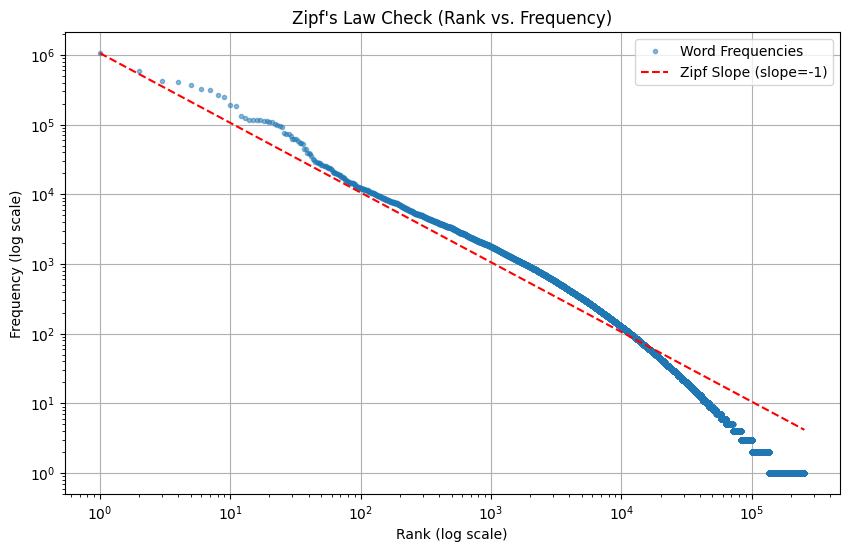

In [7]:
frequencies = sorted(word_counts.values(), reverse=True)
ranks = np.arange(1, len(frequencies) + 1)

plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies, 'o', markersize=3, alpha=0.5, label='Word Frequencies')
plt.title("Zipf's Law Check (Rank vs. Frequency)")
plt.xlabel("Rank (log scale)")
plt.ylabel("Frequency (log scale)")
plt.grid(True)

# overlay of a theoretical Zipf line (slope = -1)
C = frequencies[0] # frequency of the most frequent word
plt.loglog(ranks, C/ranks, 'r--', label='Zipf Slope (slope=-1)')
plt.legend()
plt.show()

We can observe a heavy-tailed unigram distribution consistent with Zipf’s Law, with some deviations: heavier head (most common words are "too frequent") and shorter tail (rare words are less frequent than predicted).

To create a vocabulary from this text, we first prune rare words that do not appear a minimum number of times (`MIN_COUNT` in the next cell). The observed Zipfian decay indicates we should observe a sharp decrease in the vocabulary size.

In [8]:
vocab = [word for word, count in word_counts.items()]
print(f"Size of vocabulary before pruning rare words: {len(vocab)}")


MIN_COUNT = 20 # Threshold for pruning rare words
vocab = [word for word, count in word_counts.items() if count >= MIN_COUNT]
print(f"Size of vocabulary after pruning rare words: {len(vocab)}")

Size of vocabulary before pruning rare words: 253854
Size of vocabulary after pruning rare words: 31892


We now define dictionaries `word2idx` and `idx2word` which will serve as lookup tables/maps from words to indices and indices to words, respectively.

In [9]:
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for idx, word in enumerate(vocab)}

As mentioned before in [Section 1.1, Training heuristics.], in order to adjust the impact of high-frequency words such as “the”, “a”, etc, we use subsampling. Precisely, each word $w$ in the vocab will be kept with probability: $$\min\left( \sqrt{ \frac{t}{\text{freq}(w)} } ,1\right),$$
where $t$ (`SUBSAMPLE_T` in the code below) is a hyperparameter for subsampling, and $\text{freq}(w)$ is the word's frequency in the original corpus.

In [10]:
print(f"Frequency of 'the' before subsampling: {word_counts['the']}")

Frequency of 'the' before subsampling: 1061396


In [11]:
SUBSAMPLE_T = 1e-5 # Subsampling hyperparameter.
# we go with 1e-5 as per the choice in the original paper [1]

total_words = len(text)

def subsample_prob(word):
    """
    Compute the probability of keeping a word based on its frequency.
    """
    freq = word_counts[word]/total_words
    return min(np.sqrt(SUBSAMPLE_T/freq), 1)

# we now generate and record subsampling probabilties for each word in the vocab
subsample_probs = np.zeros(len(vocab))
for word in tqdm(vocab, desc='Generating subsampling probabilities for each word in the vocab'):
    subsample_probs[word2idx[word]] = subsample_prob(word)

# we now subsample!
subsampled_text = [
    word for word in tqdm(text, desc="Generating subsampled text")
    if word in word2idx and np.random.rand() < subsample_probs[word2idx[word]]
]

# convert the words into indices for training.
subsampled_indices = np.array([word2idx[word] for word in tqdm(subsampled_text, desc='Generating subsampled indices')])

Generating subsampling probabilities for each word in the vocab: 100%|██████████| 31892/31892 [00:00<00:00, 636680.88it/s]
Generating subsampled indices: 100%|██████████| 4328911/4328911 [00:00<00:00, 6084495.96it/s]


In [12]:
subsampled_word_counts = Counter(subsampled_text)
print(f"Frequency of 'the' post subsampling: {subsampled_word_counts['the']}")

Frequency of 'the' post subsampling: 13432


In [13]:
print(f"Top five frequent words before subsampling: {word_counts.most_common(5)}")
print(f"Top five frequent words post subsampling: {subsampled_word_counts.most_common(5)}")

Top five frequent words before subsampling: [('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201)]
Top five frequent words post subsampling: [('the', 13432), ('of', 9839), ('and', 8383), ('one', 8330), ('in', 7945)]


In [14]:
print("Percentage reductions of top 10 frequent words:")
for word, count in word_counts.most_common(10):
    print(f"Word: {word}, Percentage decrease {(count-subsampled_word_counts[word])/count:.2%}")

Percentage reductions of top 10 frequent words:
Word: the, Percentage decrease 98.73%
Word: of, Percentage decrease 98.34%
Word: and, Percentage decrease 97.99%
Word: one, Percentage decrease 97.98%
Word: in, Percentage decrease 97.87%
Word: a, Percentage decrease 97.75%
Word: to, Percentage decrease 97.68%
Word: zero, Percentage decrease 97.43%
Word: nine, Percentage decrease 97.42%
Word: two, Percentage decrease 96.97%


We now save:
1. the lookup dictionaries `word2idx` and `idx2word` as a tuple to a binary file,
2. `subsampled_word_counts` as a binary file, and
3. the numpy array of indices of subsampled text `subsampled_indices` using `numpy.save`.

In [15]:
VOCAB_SAVE_PATH = 'vocab.pkl'
CORPUS_SAVE_PATH = 'corpus.npy'
COUNTS_SAVE_PATH = 'word_counts.pkl'

# saving vocab as a binary object
with open(VOCAB_SAVE_PATH, 'wb') as f:
    pickle.dump((word2idx, idx2word), f)

# word counts for negative sampling
with open(COUNTS_SAVE_PATH, 'wb') as f:
    pickle.dump(subsampled_word_counts, f)

# corpus as numpy array
corpus = np.array(subsampled_indices, dtype=np.uint32)
np.save(CORPUS_SAVE_PATH, corpus)

print(f"Final corpus size: {len(subsampled_indices):,} tokens.")

Final corpus size: 4,328,911 tokens.


**So, our subsampled corpus is a sequence of 4 million tokens!**

In [16]:
word2idx, idx2word = pickle.load(open('vocab.pkl', 'rb'))
vocab_size = len(word2idx)
corpus = np.load('corpus.npy')
word_counts = pickle.load(open('word_counts.pkl','rb'))

print(f"Vocabulary size: {vocab_size}")
print(f"No. of tokens in corpus: {len(corpus):,}")
print(f"Tail of corpus (last 10 tokens): {[idx2word[idx] for idx in corpus[-10:]]}")

Vocabulary size: 31892
No. of tokens in corpus: 4,328,911
Tail of corpus (last 10 tokens): ['followers', 'prior', 'verbatim', 'to', 'romans', 'site', 'fortress', 'masada', 'identified', 'excavated']


## 1.4 Generating Training Data

In [17]:
WINDOW_SIZE = 5  # maximum context window size

Now, we generate the skip-gram training data pairs from the corpus, as discussed in [Sec 1.1, Training heuristics.]. We use a dynamic sliding window over the corpus and width of the window for each center word is sampled uniformly from [1,...,`WINDOW_SIZE`]. For more efficient generation, we do two passes: first to iterate over each word $w_t$ and sample the context window size $k_t \sim \text{Uniform}$([1,...,`WINDOW_SIZE`]), which allows us to calculate the total number of center-context pairs we are going to generate and then preallocate numpy arrays. Then, we do a second pass to actually collect the indices for center-context pairs.

In [18]:
def generate_skipgram_data(corpus, max_window_size):
    # convert corpus to numpy array
    token_indices = np.asarray(corpus)
    num_tokens = len(token_indices)

    # first pass: we compute the total number of (center, context) pairs.
    # having a total count helps in preallocating numpy aarrays for storing the indices of the pairs
    total_pairs = 0
    dynamic_windows = np.empty(num_tokens, dtype=np.uint8) # we store the sampled window sizes in an array
    # unsigned int8 suffices since elements are <= max_window_size <= 255

    for i in tqdm(range(num_tokens), desc="First pass: counting (center, context) pairs"):
        # sample a random window size for this center word
        current_window = np.random.randint(1, max_window_size + 1)
        dynamic_windows[i] = current_window

        # calculate bounds based on the dynamic window size
        left_bound = max(0, i - current_window)
        right_bound = min(num_tokens, i + current_window + 1)

        count = (right_bound - left_bound - 1) # -1 to exclude the center itself
        total_pairs += count

    # preallocate arrays for centers and contexts
    center_indices = np.empty(total_pairs, dtype=np.uint32)
    context_indices = np.empty(total_pairs, dtype=np.uint32)

    # Second pass: fill in the preallocated arrays using the stored dynamic windows
    idx = 0
    for i in tqdm(range(num_tokens), desc="Second pass: generating (center, context) pairs"):
        current_window = int(dynamic_windows[i])
        left_bound = max(0, i - current_window)
        right_bound = min(num_tokens, i + current_window + 1)
        for j in range(left_bound, right_bound):
            if j == i:
                continue  # skip the center word itself
            center_indices[idx] = token_indices[i]
            context_indices[idx] = token_indices[j]
            idx += 1

    return np.array((center_indices, context_indices))

In [19]:
training_data = generate_skipgram_data(corpus, WINDOW_SIZE)

Second pass: generating (center, context) pairs: 100%|██████████| 4328911/4328911 [00:07<00:00, 616691.23it/s]


Let us have a look at a few examples of the training pairs.

In [20]:
for i in range(10,1000,100):
    print(idx2word[training_data[0][i]],idx2word[training_data[1][i]])

abuse whilst
anarchism the
particularly imply
mutual advocate
predecessors brought
decreed lacked
repudiated sovereignty
holy writes
dans described
anarchist enquiry


In [21]:
print(f"Total Skip-gram pairs: {len(training_data[0]):,}")

Total Skip-gram pairs: 25,974,715


Let's save these pairs using `numpy.save`.

In [22]:
SKIPGRAM_PAIRS_PATH = 'skipgram_pairs.npy'

np.save(SKIPGRAM_PAIRS_PATH, training_data)

In [23]:
SKIPGRAM_PAIRS_PATH = 'skipgram_pairs.npy'

training_data = np.load(SKIPGRAM_PAIRS_PATH)

print(f"Total Skip-gram pairs: {len(training_data[0]):,}")

Total Skip-gram pairs: 25,974,715


# 2 Negative Sampling for Approximate Training

## 2.1 A bit more theory

Although the formulation of the model in Section 1.1 builds intuition through the lens of multiclass logistic (softmax) classification, in practice, the computation of the gradient for the MLE objective requires the normalization constant $\sum_{z\in \mathcal{V}}\exp(u_{z}^{T}v_{c_{i}})$ for each training example, which is computationally expensive, especially for large vocabularies.  To address this, we rely on approximation techniques that make computations more tractable. One such method for unnormalized models was introduced in [3], namely, noise-contrastive estimation (NCE). We follow the presentation in [5], but adapted to our setting.

**Noise-Contrastive Estimation (NCE).** NCE provides a _proxy task_ whose optimization allows parameter estimation for the model without computing the normalizing constant. The core idea is to train a binary logistic classification model to distinguish samples drawn from the true data distribution from samples drawn from a known noise distribution. To this end, we introduce a known noise distribution $Q$ over the vocabulary $\mathcal{V}$, from which we can easily sample "noise" words. A pair $(c,w)$ is considered a "positive" example (label $y=1$) if $w$ is the true context word observed with the center word $c$, and a "negative" or "noise" example (label $y=0$) if $w$ is drawn from the noise distribution $Q$. The NCE method models the posterior probability that a given pair $(c,w)$ came from the true data distribution ($y=1$) versus the noise distribution ($y=0$). 

**A binary classification task.** We choose to generate, for each true pair $(c,w)$, $k$ noise samples $z_{1},\dots,z_{k}\overset{\text{i.i.d.}}{\sim} Q$​, independently of the true pairs, to have the prior probabilities: $$P(y=1)= \frac{1}{k+1}, \quad P(y=0)= \frac{k}{k+1},$$and, the likelihoods: $$P_{\theta^{*}}(c=c',w=w' \mid y=1)=P_{\theta^{*}}(w=w'\mid c=c'),$$ $$P(c=c',w=w' \mid y=0)=Q(w').$$
By the Bayes' theorem, we get the posterior probability of given pair $(c',w')$ being a true center-context pairs as: $$P_{\theta^{*}}(y=1 \mid c=c',w=w')=\frac{P_{\theta^{*}}(w=w'\mid c=c')}{P_{\theta^{*}}(w=w'\mid c=c')+ kQ(w')}.$$ Now, we try to estimate $\theta^{*}$ through $\theta\in \Theta$, yielding a candidate classifier:$$P_{\theta}(y=1 \mid c=c',w=w')=\frac{P_{\theta}(w=w'\mid c=c')}{P_{\theta}(w=w'\mid c=c')+ kQ(w')}\tag{1}$$where, recall from Section 1.1, the conditional distribution of $w$ given $c=c'$, for any $w'\in \mathcal{V}$, is given by: $$P_{\theta}(w=w'\mid c=c')=\frac{s_{\theta}(c',w')}{Z_{\theta}(c')}, \quad Z_{\theta}:c'\in \mathcal{V} \mapsto \sum_{z\in V} s_{\theta}(c',z)$$ where $s_{\theta}:(c',w') \in \mathcal{V}^{2}\mapsto \exp(u_{w'}^{T}v_{c'})$ is the unnormalized score. The expensive computation of the normalization constant $Z_{\theta}(c')$ for all training examples is precisely what we are trying to avoid.

**The estimator.** NCE adjusts the model to include an additional parameter $\epsilon=(\epsilon_{c'})_{c'\in \mathcal{V}}$ along with $\theta$, say, $\lambda:=(\theta,\epsilon)\in\Lambda$, where, for each center word realization $c'\in \mathcal{V}$: $$P_{\lambda}(w= \cdot \mid c=c')=s_{\theta}(c',\cdot) \exp(\epsilon_{c'}) \tag{2}$$i.e., $$\epsilon_{c'}=\log \left( \frac{P_{\lambda}(w=\cdot \mid c=c')}{s_{\theta}(c',\cdot)} \right)\tag{3}$$
Implicitly by (2), the parameter $\epsilon_{c'}$ helps in scaling the score $s_{\theta}(c',\cdot)$ into a probability density. And, by (3), after learning, $\hat{\epsilon}_{c'}$ provides an estimate for $$\log (1 / Z_{\hat{\theta}}(c')).$$
Note the posterior probability from (1), adjusted with the new parameters, can be rewritten as sigmoid of log-odds:
$$\begin{align*}
P_{\lambda}(y=1\mid c=c',w=w')&= \frac{P_{\lambda}(w=w' \mid c'=c')}{P_{\lambda}(w=w' \mid c'=c') +kQ(w')} \\
&=\sigma\left( \log \frac{P_{\lambda}(w=w' \mid c'=c')}{kQ(w')} \right).
\end{align*}$$

Given an observation of true center-context pair $(c',w')\in \mathcal{V}^{2}$ and associated $k$ negative pairs $\{ (c',z'_{j}) \}_{j=1}^{k} \subseteq  \mathcal{V}^{2}$, maximizing the conditional log-likelihood amounts to maximizing:
$$J_{\text{NCE}}^{(c', w',z')}:\lambda\in \Lambda \mapsto  \log P_{\lambda}(y=1\mid c=c',w=w')+ \sum_{j=1}^{k}\log P_{\lambda}(y=0 \mid c=c',w=z'_{j})$$
which is precisely the NCE objective in our setting.

The key theoretical results regarding NCE are its consistency and asymptotic normality [5, Theorem 2 & 3]. Optimizing the NCE objective provides a statistically consistent estimator for the parameter of the original skip-gram model​, albeit requiring the evaluation of $Q$ during training.

Mnih and Teh [4] observed that setting the normalizing parameter $\epsilon=0$, instead of learning them, did not affect the performance of the model. This choice is equivalent to setting the normalization constant $Z_{\theta}(c')$ as 1 for all $c'\in\mathcal{V}$ (see eq. (3)). As a consequence of this assumption, the optimization objective encourages parameters $\theta$ such that the score function $s_{\theta}$ behaves like a normalized probability. This simplified NCE objective is:
$$\begin{align*}
J_{\text{NCE-}\epsilon=0}^{(c', w',z')}:\theta\in \Theta &\mapsto  \log P_{\theta}(y=1\mid c=c',w=w')+ \sum_{j=1}^{k}\log P_{\theta}(y=0 \mid c=c',w=z'_{j})\\
&= \log \sigma\left( \log \left( \frac{s_{\theta}(c',w')}{kQ(w')} \right) \right)  + \sum_{j=1}^{k} \log \sigma\left(- \log \left( \frac{s_{\theta}(c',z'_{j})}{kQ(z'_{j})} \right) \right).
\end{align*}$$

**Negative Sampling (NS).** Mikolov et al. [2, Section 2.2] introduced "negative sampling", as a simplification of NCE, specifically in the context of word embeddings. It retains the core idea of discriminating the true target word from noise samples but simplifies the objective function.

Negative Sampling essentially neglects the $kQ$ terms from the simplified NCE objective $J_{\text{NCE}-\epsilon=0}$, and so, we consider maximizing:
$$ J_{\text{NS}}^{(c',w',z')}:\theta\in \Theta \mapsto \log \sigma(u_{w'}^{T} v_{c'}) + \sum_{j=1}^k \log \sigma(-u_{z'_{j}}^T v_{c'}) $$
Equivalently, the optimization problem is to minimize the loss function:
$$ L_{\text{NS}}^{(c',w',z')}:\theta \in \Theta \mapsto - \log \sigma(u_{w'}^{T} v_{c'}) - \sum_{j=1}^k \log  \sigma(-u_{z'_{j}}^{T} v_{c'}) $$
The noise distribution $Q$ is still used for sampling, but its values aren't needed for the loss computation itself, which makes NS computationally simpler than NCE.

While NS is derived as a simplification of NCE, it does _not_ share the same consistency property. Maximizing the NS objective does not, in general, yield parameter estimates that converge to the true maximum likelihood estimates of the original skip-gram model. However, the goal of word embedding models like skip-gram is typically not to obtain asymptotically accurate estimates of word co-occurrence probabilities, but rather to learn high-quality vector representations, that capture semantic and syntactic relationships useful for downstream tasks. The discriminative task posed by NS – pushing the score $u_{w'}^{T}v_{c'}$​ high for true pairs and low for noise pairs – proves highly effective in achieving this goal. This is evidenced by the results in [2], which demonstrated that NS can produce high-quality embeddings efficiently.

In summary, both NCE and NS provide computationally efficient alternatives to the full softmax calculation. NCE offers theoretical consistency guarantees for parameter estimation under the original model, while NS, a simpler and often faster approximation, has proven highly effective in practice for the specific goal of learning powerful word representations. **In this notebook, we will implement skip-gram with negative sampling (SGNS).**

**Some more training heuristics.** 
1. **Number of Negatives**. Number of negative samples, $k$, is a key parameter, and Mikolov et al. [2] suggested optimal ranges of $k=5–20$ (small datasets) and $k=2–5$ (large datasets). The value $k=5$ has emerged as a standard and empirically successful choice. We employ $k=5$ negative samples per positive example in this notebook.
2. **Noise distribution choice.** A natural choice for the noise distribution $Q$ is based on the unigram frequencies of words in the training corpus. As done in the `word2vec` implementation described in [2], we will use a smoothed unigram distribution by raising the unigram frequencies to the power of 0.75, that is, given a corpus of words $(w_{t})_{t=1}^{T}$,  for any $w\in \mathcal{V}$, $$Q(w):=\frac{\text{freq}(w)^{0.75}}{\sum_{z\in \mathcal{V}}\text{freq}(z)^{0.75}}, \quad \text{freq}(w):= \frac{1}{T} \sum_{i=1}^{T}\mathbb{1}_{w_{i}=w}.$$This choice reduces the probability of sampling extremely frequent words (like "the", "a") and increases the relative probability of sampling rarer words. Empirically, this adjustment has been found to improve the quality of the resulting word embeddings, particularly for less frequent words [2].
3. **Efficient negative sampling.** 
	- Directly drawing $k$ independent samples from the noise distribution $Q$ for each training pair $(c,w)$ can be computationally intensive. To optimize this, a common implementation technique, used in the original `word2vec` code [1, 2], involves pre-computing a large lookup table (e.g., containing $10^{8}$ entries in the original implementation; $10^{6}$ in this notebook). This table stores _word indices_ from the vocabulary $\mathcal{V}$, with index of each word $w$ repeated proportionally to its smoothed noise probability $Q(w)$. So, to draw $k$ negative samples for a given training instance, we sample $k$ word indices uniformly from the table, and then index the vocabulary. 
	- This approach replaces $k$ sampling operations from the noise distribution with $k$ constant-time uniform sampling operations and table lookups, reducing the complexity for drawing $k$ samples to only $\mathcal{O}(k)$ time. There is a small, inherent chance that the true context word $w$ may be selected as a negative sample (a "collision"). The expected number of such occurrences is $k\times Q(w)$ per training instance, which is usually negligible. While it is possible to filter these collisions explicitly, the additional complexity is generally not justified since empirical results demonstrate little impact on overall performance.
	- Finally, as one last trick for efficiency, instead of sampling negatives using the CPU with PyTorch's DataLoader, we offload the actual sampling task to the GPU: precisely, we do on-the-fly negative sampling for an entire batch at once, inside the training loop.

## 2.2 Negative Sampling Lookup Table

For efficiently building the negative sampling lookup table, we utilize tensors. And, first order of business is to convert the word frequencies into a tensor.

In [24]:
word_counts_tensor = torch.tensor(
    [word_counts[idx2word[i]] for i in range(len(word2idx))], 
    dtype=torch.float32
)

Let's verify this tensor is built correctly by checking frequency of 'the':

In [25]:
word_counts['the'] == word_counts_tensor[word2idx['the']]

tensor(True)

Let's now create the smoothed unigram distribution with power 0.75 as mentioned in [Sec 2.1, Some more training heuristics.]

In [26]:
# compute the noise distribution
probs = word_counts_tensor.pow(0.75).to(device)
probs /= probs.sum()  # normalizing to create a probability distribution

Finally, we create a lookup table of size $10^6$ containing word indices from the vocab using the noise distribution `probs`. Also, since the negative sampling table is used purely for indexing and sampling negative examples, not for learning parameters, we use `.detach()` so that this tensor is not tracked by autograd in the computational graph.

In [27]:
# build a negative sampling table of fixed size
NEG_TABLE_SIZE = int(1e6)

# using PyTorch for sampling
neg_table = torch.multinomial(probs, NEG_TABLE_SIZE, replacement=True)

# detaching to ensure no gradients are tracked
neg_table = neg_table.detach()

# moving to gpu
neg_table = neg_table.to(device)

Let's verify the size of this table.

In [28]:
neg_table.shape

torch.Size([1000000])

## 2.3 Dataset and DataLoader

We now define a custom dataset class retrieve center-context pairs, as tensors, using indexing. Note that we do not do any negative sampling here, because the data processing is done by CPU, and it is more efficient to utilize the GPU and do negative sampling for an entire (mini)batch at once, inside the training loop.

In [29]:
class SkipGramDataset(Dataset):
    def __init__(self, pairs):
        """
        Args: pairs: 2 x n_data array of (center, context) word pairs.
        """
        self.pairs = torch.tensor(pairs, dtype=torch.long)  # (center, context) word pairs as a Tensor

    def __len__(self):
        return len(self.pairs[0])  # number of (center, context) pairs

    def __getitem__(self, idx):
        # ONLY returns the center and context words
        center, context = self.pairs[:, idx]
        return center, context
        # No negative sampling here! We will do that inside the training loop using GPU

We will be using PyTorch's `DataLoader` to prepare batches for training. But, by default, the data loading happens in the main process, which can be a bottleneck and lead to idle time for the GPU or CPU waiting for data. Fortunately, `DataLoader` has a parameter called `num_workers`, which  controls how many subprocesses (workers) are used to load and preprocess data in parallel. The only catch is, Jupyter notebook causes some incompatibility issues with PyTorch's multiprocessing capabilities. A workaround for this is defining `SkipGramDataset` in a different .py file and then importing it here. We do so precisely in the next cell. 

Source of the workaround: https://stackoverflow.com/questions/68756034/pytorch-problem-my-jupyter-stuck-when-num-workers-0, (`rosul`'s comment)


In [30]:
del SkipGramDataset
from dataset import SkipGramDataset
dataset = SkipGramDataset(training_data)

We now define some reproducibility arguments for the PyTorch DataLoader. Taken verbatim from https://pytorch.org/docs/stable/notes/randomness.html#dataloader.

In [31]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)

As in the case of the dataset class, the above `seed_worker` function also runs into issue with PyTorch multiprocessing unless its imported from a separate .py file, so, we do so in the next cell.

In [32]:
from dataset import seed_worker

We also use:
- `persistent_workers=True`: This keeps the DataLoader's worker processes alive between epochs, reducing the overhead of repeatedly spawning and destroying them. This helps avoid potential slowdowns or freezes, especially when `num_workers > 0`.
- `pin_memory=True`: This enables faster data transfer from host (CPU) memory to device (GPU) memory. When set to `True`, the DataLoader allocates the samples in page-locked memory, which allows `torch.Tensor` objects to be moved to GPUs more efficiently via `non_blocking=True` transfers (which will be done inside the training loop, batchwise).

The following choice of batch size and number of workers was found to be optimal for M1 Air over several training runs.

In [33]:
# Hyperparameter for the dataloader
BATCH_SIZE = 8192
NUM_WORKERS = 4

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers = NUM_WORKERS,
    persistent_workers=True,
    pin_memory=True,
    # reproducibility params
    worker_init_fn=seed_worker,
    generator=g,
)

Note that for CUDA devices, `pin_memory=True` flag is crucial, as it explicitly improves the efficiency of the data copying process between host and GPU memory.

With the MPS backend, since Apple Silicon uses a Unified Memory Architecture, so, the CPU and GPU share the same physical pool of memory with high bandwidth access for both. The performance "gains" associated with page-locked (pinned) memory may not be applicable although the flag is still supported. See https://github.com/pytorch/pytorch/issues/86060.

# 3 Training using Neural Networks

## 3.1 Architecture



The skip-gram model, particularly when trained with the Negative Sampling loss $L_{\text{NS}}$​ derived in Section 2.1, can be effectively realized using a shallow neural network architecture.

Recall from Section 1.1, that the model is parametrized by $\theta=(u_{w},v_{w})_{w\in \mathcal{V}}\in (\mathbb{R}^{d}\times \mathbb{R}^{d})^{|\mathcal{V}|}$. Our neural network's architecture involves precisely two embedding layers:
1. `center_embeddings`: The matrix $(u_{w}^{T})_{w\in \mathcal{V}}\in \mathbb{R}^{|\mathcal{V}|\times d}$ of center word embeddings, serving as a lookup table. This is implemented using `nn.Embedding(vocab_size, embed_dim)`.
2. `context_embeddings`: The matrix $(v_{w}^{T})_{w\in \mathcal{V}}\in \mathbb{R}^{|\mathcal{V}|\times d}$ of context word embeddings, serving as a lookup table. This is also implemented using `nn.Embedding(vocab_size, embed_dim)`.

We choose to initialize both of them using Xavier (Glorot) initialization, differing from the original `word2vec` C code, which used $\text{Uniform}([-r,r])$ where $r:=1/d$. The forward pass only returns the embeddings for a given batch of (center, context, negatives) words.

In [34]:
import torch
import torch.nn as nn

class SkipGramNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        """
        Args:
            vocab_size: Number of words in the vocabulary.
            embed_dim: Dimensionality of the word embeddings.
        """
        super().__init__()

        # Embedding matrices
        self.center_embeddings = nn.Embedding(vocab_size, embed_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embed_dim)

        # Xavier (Glorot) initialization
        nn.init.xavier_uniform_(self.center_embeddings.weight)
        nn.init.xavier_uniform_(self.context_embeddings.weight)

    def forward(self, center_words, context_words, negative_words):
        """
        let B:=batch_size, N:=num_negatives, d:=embedding_dim.
        Args:
            center_words: Tensor of shape (B,)
            context_words: Tensor of shape (B,)
            negative_words: Tensor of shape (B, N)
        Returns:
            (center_embed, context_embed, negative_embed): array of embeddings 
        """
        # lookup embeddings for center, context, and negative words
        center_embed = self.center_embeddings(center_words)  # (B, d)
        context_embed = self.context_embeddings(context_words)  # (B, d)
        negative_embed = self.context_embeddings(negative_words)  # (B, N, d)

        return center_embed, context_embed, negative_embed

**Negative Sampling Loss.**
We now create a function to calculate $L_{\text{NS}}$ - the negative sampling loss we introduced in Section 2.1. - for a batch of size, say, $B$ as: $$\frac{1}{B} \sum_{i=1}^{B}L_{\text{NS}}(\theta; c^{i},w^{i},(z^{i}_{j})_{j=1}^{k})=-\frac{1}{B} \sum_{i=1}^{B} \left[\log \sigma(u_{w^{i}}^{T} v_{c^{i}}) + \sum_{j=1}^k \log (\sigma(-u_{z^{i}_{j}}^{T} v_{c^{i}}))\right].$$

The embeddings will be retrieved by the forward pass. We first compute the dot product between the embeddings of the center-context and center-negative pairs. Then, we use the `logsigmoid` function from `nn.functional` to calculate the contribution of positive pairs and negative pairs. This `logsigmoid` is numerically more stable than composing log and sigmoid functions.

In [35]:
import torch.nn.functional as F

def SGNS_Loss(center_embed, context_embed, negative_embed):
    """
    Implements the Skip-Gram with Negative Sampling (SGNS) loss.
    let B:=batch_size, N:=num_negatives, d:=embedding_dim.
    Args:
        center_embed: center word embeddings. (B, d) 
        context_embed: context word embeddings. (B, d) 
        negative_embed: negative  embeddings. (B, N, d)

    Returns:
        loss: L_{NS} loss (averaged over batch).
    """
    # positive dot products: <u_w^i, v_c^i> for batch i=1,..,B
    pos_dot = torch.sum(center_embed * context_embed, dim=1)  # shape: (B,)

    # negative dot products: <u_z^i_j, v_c^i> for all j=1,...,N, for batch i=1,...,B
    neg_dot = (negative_embed @ center_embed.unsqueeze(2)).squeeze(2)  # shape: (B, N)
    # unsqueeze(2) to convert center_embed shape form (B, d) to (B, d, 1)
    # so, (batch) matrix mult. with negative_embed (B, N, d) as prefactor, is then well-defined.
    # product has shape (B, N, 1), so, squeeze (2) to remove the singleton dimension and get the shape (B, N)

    # loss terms
    pos_loss = F.logsigmoid(pos_dot)  # (B,)
    neg_loss = F.logsigmoid(-neg_dot).sum(dim=1)  # (B,) summing over the negatives

    # final loss: averaged over batch
    return -(pos_loss + neg_loss).mean()

Empirically, embedding dimensions in the range of 100 to 300 are often sufficient for learning useful word representations. The original word2vec papers also experimented with higher dimensions (e.g., up to 1000), but gains beyond 300 were often marginal for most downstream tasks. In this notebook, we will use $\mathbb{R}^{200}$ as our embedding dimension, which strikes a good balance between representational capacity and computational efficiency.

In [36]:
# instantiate the model
EMBED_DIM = 200
model = SkipGramNegativeSampling(vocab_size, EMBED_DIM).to(device)

We utilize `torch.compile()` to optimize the model for execution on the device (requires PyTorch 2.0+!). See https://pytorch.org/docs/stable/generated/torch.compile.html.

In [37]:
# model = torch.compile(model)
model = torch.compile(model, backend="aot_eager") # if on Apple Silicon; standard compile()'s backend is incompatible.  

## 3.2 What is the truth?

We remind that we are in the context of unsupervised/self-supervised learning. So, it is hard to define "ground truth" when given a corpus to try and learn word embeddings from. So, the concept of validation set does not really make sense in this context. But, it is futile to keep training till some arbitrary number of epochs and hope for good quality embeddings. So, we choose to rely on some *extrinsic evaluations*. Particularly, two types of scores:

**I. Similarities.**
We use the WordSimilarity-353 dataset, which contains set of word pairs along with human-assigned similarity scores. The actual score we use is the [Spearman rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) between the human similarity scores from the dataset and the (cosine) similarities produced by the model itself. This works by converting both sets of scores into ranks. Then, it calculates the Pearson correlation between these ranks. See [WordSim353 - ACL Wiki](https://aclweb.org/aclwiki/WordSimilarity-353_Test_Collection_(State_of_the_art)).

**II. Analogies.** The original `word2vec` papers [1, 2] used analogical reasoning tasks on a dataset, now colloquially called "Google analogy test set". See [Google analogy test set - ACL Wiki](https://aclweb.org/aclwiki/Google_analogy_test_set_(State_of_the_art)). Quoting from [2] :
> The task consists of analogies such as “Germany” : “Berlin” :: “France” : ?, which are solved by finding a vector $x$ such that vec($x$) is closest to vec(“Berlin”) - vec(“Germany”) + vec(“France”) according to the cosine distance (we discard the input words from the search). This specific example is considered to have been answered correctly if $x$ is “Paris”. The task has two broad categories: the syntactic analogies (such as “quick” : “quickly” $\text{:}\text{:}$ “slow” : “slowly”) and the semantic analogies, such as the country to capital city relationship.


Both these datasets are available through `gensim`, and their corresponding scores can be evaluated with `gensim.models.KeyedVectors`'s methods, and we do so precisely in the next cell: defining an evaluation function that takes in a model and returns an array of the analogy accuracy and Spearman rank correlation coefficient:

In [38]:
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

vocab = [idx2word[idx] for idx in range(len(word2idx))] 

def evaluate_with_gensim(model, center = 1):
    # extract embeddings from the model as numpy array on CPU
    if center == 1:
        embeddings = model.center_embeddings.weight.data.detach().cpu().numpy()
    else:
        embeddings = model.context_embeddings.weight.data.detach().cpu().numpy()

    # we create a KeyedVectors object: a lookup-table from word to embeddings
    wv = KeyedVectors(EMBED_DIM) 
    wv.add_vectors(vocab, embeddings)  # Add word vectors

    # Evaluate on Google's analogy dataset
    analogy_accuracy = wv.evaluate_word_analogies(datapath("questions-words.txt"))[0]
    # Evaluate on WordSim353 dataset; this is Spearman rank correlation coefficient
    similarity_score = wv.evaluate_word_pairs(datapath("wordsim353.tsv"))[1][0]

    return np.array((analogy_accuracy, similarity_score))

Note that, for now, by default we only use the center embeddings as _the_ embeddings for evaluation. There is a flag in the above functions params which will allows us to evaluate the scores for context embeddings as well.

See more at: 
- [KeyedVectors](https://radimrehurek.com/gensim/models/keyedvectors.html#module-gensim.models.keyedvectors).
- [evaluate_word_pairs](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.evaluate_word_pairs).
- [evaluate_word_analogies](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.evaluate_word_analogies).

Finally, we *choose* to weigh both these scores equally, so, we define _an_ "extrinsic" evaluation score as the mean: $$\text{extrinsic score}:=\frac{\text{analogy accuracy}+\text{Spearman rank corr. coefficient}}{2}.$$This score will be computed inside the training loop at the end of every epoch, allowing it to be used as a measure for early stopping rule.

## 3.3 Training Loop

In [39]:
# total epochs for a run
NUM_EPOCHS = 10

# Learning Rates
INITIAL_LR = 0.001 # starting LR for Adam/AdamW
# INITIAL_LR = 0.025 # starting LR for SGD 
MIN_LR = INITIAL_LR * 0.0001 # for LR scheduling

# number of negatives to sample for each center-context pair
NUM_NEGATIVE = 5 

# threshold for early stopping rule based on extrinsic score
PATIENCE = 3

Adam-family optimizers were found to converge faster and produces decent quality of embeddings right after 1 epoch; compared to SGD, which produces somewhat subpar quality of embeddings even after a few epochs.

In [40]:
# optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=0, weight_decay=0)
optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR, weight_decay=0)
# optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=0)

In [41]:
# flag for LR scheduling
LR_SCHEDULING = False # not necessary for Adam/AdamW

Now, we finally implement the training loop for skip-gram. The following code block has 3 keys features:
1. Early stopping rule based on the extrinsic score constructed in Section 3.2,
2. Learning Rate (linear) scheduling (if `LR_SCHEDULING==True`), and
3. most crucially, on-the-fly batchwise negative sampling using GPU: let $k$ be the number of negative samples for each positive pair, then for each batch, with size say $B$, we sample $B\times k$ negatives uniformly from the negative sampling table created in Section 2.2.

In [42]:
print("\n" + "="*100)
print(f"Starting training for {NUM_EPOCHS} Epochs")
print(f"Device: {device}")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Initial LR: {INITIAL_LR}")
print(f"LR Scheduling: {LR_SCHEDULING}")
print(f"Patience for early stopping rule: {PATIENCE}")
print("="*100 + "\n")

best_loss = float('inf')
start_time = time.time()

# calculate total number of training steps for LR decay
total_steps = len(dataloader) * NUM_EPOCHS
steps_processed = 0

# variables for early stopping rule
epochs_without_improvement = 0
best_extrinsic_score = np.array([-float("inf")]*2) # recall, higher is better, for both analogy and similarity score.
epochs_completed = 0

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    model.train() # set model to training mode

    # we create a tqdm iterable with the dataloader to show progress bars for each epoch
    batch_bar = tqdm(
        enumerate(dataloader),
        total=len(dataloader),
        desc=f"Epoch {epoch+1}/{NUM_EPOCHS}",
        unit="batch",
        position=0,
    )

    running_loss = 0.0
    num_batches = 0
    current_lr = INITIAL_LR
    
    for i, (center_words, context_words) in batch_bar:
        # Learning Rate Decay
        if LR_SCHEDULING:        
            # calculate progress (proportion of total steps completed)
            progress = steps_processed / total_steps
            # linearly decay LR from INITIAL_LR down to MIN_LR
            current_lr = INITIAL_LR * (1.0 - progress)
            # ensure LR doesn't drop below the minimum threshold
            current_lr = max(MIN_LR, current_lr)
    
            # apply the decayed learning rate to the optimizer
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr

        # move batch to device
        center_words = center_words.to(device, non_blocking=True) 
        context_words = context_words.to(device, non_blocking=True)
        # non_blocking flag allows using asynchronous GPU copies, for overlap between data transfers and computation, 
        # https://pytorch.org/docs/stable/notes/cuda.html#cuda-memory-pinning
        # once again, might be inapplicable to Apple Silicon due to unified memory 

        # perform vectorized Negative Sampling ON THE BATCH
        current_batch_size = center_words.size(0)
        # sample indices for the whole batch at once
        # shape: (current_batch_size, num_neg)
        neg_indices = torch.randint(
            0, NEG_TABLE_SIZE,
            (current_batch_size, NUM_NEGATIVE),
            device=device # to sample directly on the target device!
            ) 

        # lookup negative samples using the table on the device
        negative_words = neg_table[neg_indices] # (batch_size, num_neg)

        # Forward pass
        optimizer.zero_grad()
        center_embed, context_embed, negative_embed = model(center_words, context_words, negative_words)
        loss = SGNS_Loss(center_embed, context_embed, negative_embed)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # update tracking variables
        running_loss += loss.item()
        num_batches += 1
        steps_processed += 1 # increment steps processed after using it for LR calculation

        # update tqdm progress bar
        avg_loss_so_far = running_loss / num_batches
        batch_bar.set_postfix(
            loss=f"{avg_loss_so_far:.6f}",
            lr=f"{current_lr:.4e}" # display current LR
        )

    # Epoch Summary
    epoch_loss = running_loss / num_batches
    epoch_time = time.time() - epoch_start_time
    
    # extrinsic score evaluations 
    model.eval()
    current_extrinsic_score = evaluate_with_gensim(model) 
    # this is a bit expensive to compute; takes ~10-20seconds. 

    print("\n" + "-"*100)
    print(f"Epoch {epoch+1} Summary:")
    print(f"Time: {epoch_time:.2f}s ({epoch_time/60:.2f} mins) | Avg Loss: {epoch_loss:.6f} | Final LR for Epoch: {current_lr:.4e}")
    print(f"Accuracy on Google's analogy dataset: {current_extrinsic_score[0]:.4f}")
    print(f"Spearman rank correlation with WordSimilarity-353: {current_extrinsic_score[1]:.4f}")
    print("-"*100 + "\n")

    # Save model
    if current_extrinsic_score.mean() > best_extrinsic_score.mean():
        best_extrinsic_score = current_extrinsic_score
        torch.save(model.state_dict(), "best_model.pt") 
        print(f"Saved new best model (extrinsic score improved to {best_extrinsic_score.mean():.6f})\n")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement +=1

    epochs_completed +=1 
    
    # Save checkpoint every epoch
    # torch.save(model.state_dict(), f"epoch{NUM_EPOCHS}.pt")

    if epochs_without_improvement == PATIENCE:
        print(f"Early stopping triggered; extrinsic score has not improved for {PATIENCE} epochs.")
        break

# Final Summary 
total_time = time.time() - start_time
print("="*100)
print(f"TRAINING COMPLETE!")
print(f"Total epochs completed in this run: {epochs_completed}")
print(f"Total Time: {total_time:.2f}s ({total_time/60:.2f} mins)")
print(f"Best accuracy on Google's analogy dataset: {best_extrinsic_score[0]:.4f}")
print(f"Best Spearman rank correlation with WordSimilarity-353: {best_extrinsic_score[1]:.4f}")
print("="*100)


Starting training for 10 Epochs
Device: mps
Optimizer: Adam
Initial LR: 0.001
LR Scheduling: False
Patience for early stopping rule: 3



Epoch 1/10: 100%|██████████| 3171/3171 [03:04<00:00, 17.16batch/s, loss=2.535881, lr=1.0000e-03]



----------------------------------------------------------------------------------------------------
Epoch 1 Summary:
Time: 186.50s (3.11 mins) | Avg Loss: 2.535881 | Final LR for Epoch: 1.0000e-03
Accuracy on Google's analogy dataset: 0.1578
Spearman rank correlation with WordSimilarity-353: 0.5665
----------------------------------------------------------------------------------------------------

Saved new best model (extrinsic score improved to 0.362112)



Epoch 2/10: 100%|██████████| 3171/3171 [03:07<00:00, 16.91batch/s, loss=2.215396, lr=1.0000e-03]



----------------------------------------------------------------------------------------------------
Epoch 2 Summary:
Time: 188.23s (3.14 mins) | Avg Loss: 2.215396 | Final LR for Epoch: 1.0000e-03
Accuracy on Google's analogy dataset: 0.2556
Spearman rank correlation with WordSimilarity-353: 0.6698
----------------------------------------------------------------------------------------------------

Saved new best model (extrinsic score improved to 0.462723)



Epoch 3/10: 100%|██████████| 3171/3171 [03:18<00:00, 15.98batch/s, loss=2.127752, lr=1.0000e-03]



----------------------------------------------------------------------------------------------------
Epoch 3 Summary:
Time: 199.13s (3.32 mins) | Avg Loss: 2.127752 | Final LR for Epoch: 1.0000e-03
Accuracy on Google's analogy dataset: 0.2723
Spearman rank correlation with WordSimilarity-353: 0.6918
----------------------------------------------------------------------------------------------------

Saved new best model (extrinsic score improved to 0.482037)



Epoch 4/10: 100%|██████████| 3171/3171 [03:17<00:00, 16.10batch/s, loss=2.067945, lr=1.0000e-03]



----------------------------------------------------------------------------------------------------
Epoch 4 Summary:
Time: 197.76s (3.30 mins) | Avg Loss: 2.067945 | Final LR for Epoch: 1.0000e-03
Accuracy on Google's analogy dataset: 0.2749
Spearman rank correlation with WordSimilarity-353: 0.7075
----------------------------------------------------------------------------------------------------

Saved new best model (extrinsic score improved to 0.491237)



Epoch 5/10: 100%|██████████| 3171/3171 [02:59<00:00, 17.63batch/s, loss=2.022705, lr=1.0000e-03]



----------------------------------------------------------------------------------------------------
Epoch 5 Summary:
Time: 180.57s (3.01 mins) | Avg Loss: 2.022705 | Final LR for Epoch: 1.0000e-03
Accuracy on Google's analogy dataset: 0.2707
Spearman rank correlation with WordSimilarity-353: 0.7040
----------------------------------------------------------------------------------------------------



Epoch 6/10: 100%|██████████| 3171/3171 [03:01<00:00, 17.43batch/s, loss=1.989027, lr=1.0000e-03]



----------------------------------------------------------------------------------------------------
Epoch 6 Summary:
Time: 182.72s (3.05 mins) | Avg Loss: 1.989027 | Final LR for Epoch: 1.0000e-03
Accuracy on Google's analogy dataset: 0.2589
Spearman rank correlation with WordSimilarity-353: 0.6987
----------------------------------------------------------------------------------------------------



Epoch 7/10: 100%|██████████| 3171/3171 [03:00<00:00, 17.53batch/s, loss=1.963879, lr=1.0000e-03]



----------------------------------------------------------------------------------------------------
Epoch 7 Summary:
Time: 181.73s (3.03 mins) | Avg Loss: 1.963879 | Final LR for Epoch: 1.0000e-03
Accuracy on Google's analogy dataset: 0.2589
Spearman rank correlation with WordSimilarity-353: 0.6923
----------------------------------------------------------------------------------------------------

Early stopping triggered; extrinsic score has not improved for 3 epochs.
TRAINING COMPLETE!
Total epochs completed in this run: 7
Total Time: 1448.11s (24.14 mins)
Best accuracy on Google's analogy dataset: 0.2749
Best Spearman rank correlation with WordSimilarity-353: 0.7075


# 4 Evaluating and Visualizing Word Embeddings

First order of business is to load the best model before early stopping was triggered. Due to wrapping the model with `torch.compile`, the model embeddings/keys are prefixed with `_orig_mod`. We remove that in the next cell before loading the state dictionary from the checkpoint.

In [43]:
checkpoint = torch.load("best_model.pt")

# strip the '_orig_mod.' prefix
new_state_dict = {k.replace('_orig_mod.', ''): v for k, v in checkpoint.items()}

model = SkipGramNegativeSampling(vocab_size, EMBED_DIM).to(device)
model.load_state_dict(new_state_dict)

<All keys matched successfully>

Let's verify the best extrinsic score.

In [44]:
model.eval()
best_extrinsic_score = evaluate_with_gensim(model)
print(f"Best accuracy on Google's analogy dataset: {best_extrinsic_score[0]:.4f}")
print(f"Best Spearman rank correlation with WordSimilarity-353: {best_extrinsic_score[1]:.4f}")

Best accuracy on Google's analogy dataset: 0.2749
Best Spearman rank correlation with WordSimilarity-353: 0.7075


We can also now check for the scores using context embeddings.

In [45]:
print("Scores using context embeddings:")
best_extrinsic_score = evaluate_with_gensim(model, center = 0)
print(f"Best accuracy on Google's analogy dataset: {best_extrinsic_score[0]:.4f}")
print(f"Best Spearman rank correlation with WordSimilarity-353: {best_extrinsic_score[1]:.4f}")

Scores using context embeddings:
Best accuracy on Google's analogy dataset: 0.2652
Best Spearman rank correlation with WordSimilarity-353: 0.6843


The original skip-gram word2vec trained on 700M-1B words to achieve analogy accuracies ranging from 45~55% [1]. Our corpus post subsampling was of length 4 million tokens, so, a score of 27% is not terrible.

We already have some quantitative measures of the quality of embeddings using the extrinsic scores. Now, we will test the embeddings with a few examples of word similarity and analogy tasks. First, we extract embeddings from the trained model. Note that, there are two embeddings: i) `center_embeddings`, ii) `context_embeddings`. `context_embeddings` was required as part of the training process, but it is a standard to use `center_embeddings` for evaluation tasks as they are found to better encode semantics in the word embedding space.

In [46]:
center_embeddings = model.center_embeddings.weight.detach().cpu().numpy()
context_embeddings = model.context_embeddings.weight.detach().cpu().numpy()
embeddings = center_embeddings

## 4.1 Word Similarity

A common measure of similarity in the context of word embeddings is the cosine similarity, which is defined as the cosine of the angle between two word vectors in the embedding space. We define it precisely in the next cell.

In [47]:
def cosine_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

We now define a function that retrieves the most similar words to a given target, using cosine similarity in the embedding space.

In [48]:
def find_similar(word, top_n=5):
    if word not in word2idx:
        return []
    idx = word2idx[word]
    target_emb = embeddings[idx] # retrieving the word vector
    similarities = []
    for i in range(vocab_size):
        sim = cosine_sim(target_emb, embeddings[i])
        similarities.append((idx2word[i], sim))
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True) # sorting using a lambda map (sorting based on its second component: the similarity)
    # Skip the word itself and return the top_n similar words
    return [(w, sim) for w, sim in similarities if w != word][:top_n]

In [49]:
find_similar("paris")

[('montparnasse', 0.66063917),
 ('parisian', 0.5962468),
 ('rodin', 0.56619),
 ('louvre', 0.56420135),
 ('madame', 0.5603592)]

In [50]:
# russian author 
find_similar("fyodor")

[('dostoevsky', 0.7945404),
 ('satirist', 0.7052082),
 ('playwright', 0.6839104),
 ('novelist', 0.6687703),
 ('essayist', 0.6592223)]

In [51]:
# common nouns
find_similar("father")

[('mother', 0.66258526),
 ('son', 0.638459),
 ('wife', 0.6015169),
 ('betrothed', 0.595415),
 ('eldest', 0.5886222)]

In [52]:
find_similar("polytechnique", top_n=10)

[('rieure', 0.80673105),
 ('normale', 0.7956553),
 ('sup', 0.7581558),
 ('cole', 0.73477846),
 ('ecole', 0.70684),
 ('coll', 0.7048267),
 ('institut', 0.66745186),
 ('acad', 0.6500867),
 ('lyc', 0.64926386),
 ('sie', 0.6403854)]

This last example hints at a fault in our corpus preparation: words with accent marks are split into multiple tokens. For example: $$\text{supérieure} \mapsto \text{sup}, \text{rieure}.$$

Unfortunately this is an issue inherent to the `text8` dataset, which comes preprocessed, so even replaces all accented characters with whitespace:

In [53]:
import chardet  # might need to installed using pip

# to detect the encoding of the file
with open(CORPUS_PATH, "rb") as f:
    raw_data = f.read(100000)  
    result = chardet.detect(raw_data)
    print(result)

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


In [54]:
with open(CORPUS_PATH, "r", encoding="ascii") as f:
    text = f.read()
idx = text.find("rieure") 
text[idx-20:idx+10] # to check if the accented characters are whitespaces

'he cole normale sup rieure mem'

## 4.2 Word Analogies

We had already seen the `gensim`'s methods to evaluate analogies in the extrinsic score approach during training. Now, we implement a function from scratch to evaluate word analogies, more precisely, given an analogy `word1:word2 :: word3:word4`, then, we do the vector arithmetic in the embedding space:
$$\text{result}=\text{vec}(\text{'word2'})-\text{vec}(\text{'word1'})+\text{vec}(\text{'word3'}),$$
and then we use the cosine similarity between all word vectors in the embedding space and the $\text{result}$ vector to find the most similar words to it, excluding all the inputs words (as was done in [2]), and, ideally, `word4` should be pop up as the most similar word to $\text{result}$.

In [55]:
def analogy(word1, word2, word3, top_n=5):
    # first we do the vector arithmetic in the embedding space.
    # word2 - word1 + word3
    vec = embeddings[word2idx[word2]] - embeddings[word2idx[word1]] + embeddings[word2idx[word3]]

    # we create now a similarity dictionary of cosine similarities
    # between resultant vec and all words in our vocab
    similarities = {
        word: cosine_sim(vec, embeddings[idx])
        for word, idx in word2idx.items() 
        if word not in (word1, word2, word3) # exclude the input words; this is a standard approach, as done in [2].
    }
    return sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_n]

In [56]:
print(analogy("france", "paris", "germany")) # expected output: berlin

[('berlin', 0.5747989), ('leipzig', 0.5336701), ('munich', 0.52910006), ('gdr', 0.5250273), ('speer', 0.52141494)]


In [57]:
print(analogy("man", "king", "woman"))  # expected output: "queen"

[('concubine', 0.51476216), ('marries', 0.51265407), ('throne', 0.4911832), ('betrothed', 0.4894316), ('concubines', 0.47955185)]


In [58]:
print(analogy("france", "paris", "india")) # expected output: delhi

[('delhi', 0.50723225), ('pune', 0.4870246), ('bangalore', 0.48350576), ('gujarat', 0.47575718), ('calcutta', 0.47168258)]


The embeddings seem to work well enough for some capital-country analogies, but fail the popular `king-man+woman=queen` example used in the context of embeddings. Let's check if, at the very least, their cosine similarity is positive:

In [59]:
print(cosine_sim(embeddings[word2idx["king"]], embeddings[word2idx["queen"]]))

0.46027672


## 4.3 Visualizing Word Neighbours using `t-SNE`
We now aim to visualize high-dimensional word embeddings in a 2D plot using `t-SNE` ([t-distributed Stochastic Neighbour Embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)). `t-SNE` is a dimensionality reduction technique effective at revealing local structure in high-dimensional data, making it suitable for visualizing how words relate to each other based on their embedding vectors. The process involves first selecting a target word, and finding its nearest neighbours by calculating the cosine similarity between its embedding and all other embeddings in the vocabulary. Then, `t-SNE` is applied to the high-dimensional embedding vectors of just this selected subset (the target word and its closest neighbours) to reduce them to two dimensions for plotting. Finally, we create a scatter plot where each point represents a word, ideally showing semantically similar words clustered together in the 2D space.

In [60]:
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity # using sklearn's implementation for efficiency

def tsne_plot(target_word="paris", num_words_to_plot=50):
    
    # finding nearest neighbors based on cosine similarity
    target_idx = word2idx[target_word]
    target_embedding = embeddings[target_idx].reshape(1, -1) # Reshape for cosine_similarity


    # calculate cosine similarities between the target word and all words
    # the sklearn function handles comparing one vector (target_embedding) against many (embeddings) efficiently.
    # it returns a (1, vocab_size) array, so we take the first row [0].
    similarities = cosine_similarity(target_embedding, embeddings.astype(np.float32))[0] # get the single row of similarities


    # get the indices of the top n most similar words (including the target itself)
    # np.argsort sorts in ascending order, so we slice from the end for descending order
    most_similar_indices = np.argsort(similarities)[-num_words_to_plot:] # indices of top n words


    # prepare data for t-sne
    selected_embeddings = embeddings[most_similar_indices]
    selected_words = [idx2word[i] for i in most_similar_indices]


    print(f"Selected words: {selected_words}")

    # apply t-sne
    tsne = TSNE(
        n_components=2,        # to reduce to 2 dimensions
        random_state=42,       # for reproducibility
        max_iter=5000,           # default is 1000 iters, we do 5000 for better convergence
    )             

    embeddings_2d = tsne.fit_transform(selected_embeddings)  # shape: (num_words_to_plot, 2)
    print("t-SNE finished.")

    # we finally create a plot 
    plt.figure(figsize=(14, 14)) 
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='steelblue', alpha=0.7)

    # annotate points with words
    for i, word in enumerate(selected_words):
        plt.annotate(
            word,
            xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]),
            xytext=(5, 2), # small offset from the point
            textcoords='offset points',
            ha='right',
            va='bottom',
            fontsize=9
            )

    # highlight the target word
    target_plot_idx = selected_words.index(target_word) # find where the target word is in the plotted list
    plt.scatter(embeddings_2d[target_plot_idx, 0], embeddings_2d[target_plot_idx, 1],
                c='red', s=100, label=f'target: {target_word}', edgecolors='black') # highlight target
    plt.legend()


    plt.title(f"t-SNE visualization of '{target_word}' and its {num_words_to_plot-1} nearest neighbors")
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.grid(True)
    plt.show()

Selected words: ['lille', 'cabaret', 'camus', 'ville', 'antoinette', 'monet', 'viollet', 'michel', 'marie', 'cahiers', 'beaux', 'lettre', 'tudes', 'caen', 'france', 'palais', 'polytechnique', 'teau', 'bordeaux', 'chapelle', 'lettres', 'alexandre', 'germain', 'nantes', 'soci', 'dans', 'pissarro', 'normale', 'acad', 'mie', 'marseille', 'sorbonne', 'mistral', 'lyc', 'rieure', 'salon', 'maison', 'rouen', 'triomphe', 'diderot', 'nouvelle', 'sur', 'braque', 'seine', 'madame', 'louvre', 'rodin', 'parisian', 'montparnasse', 'paris']
t-SNE finished.


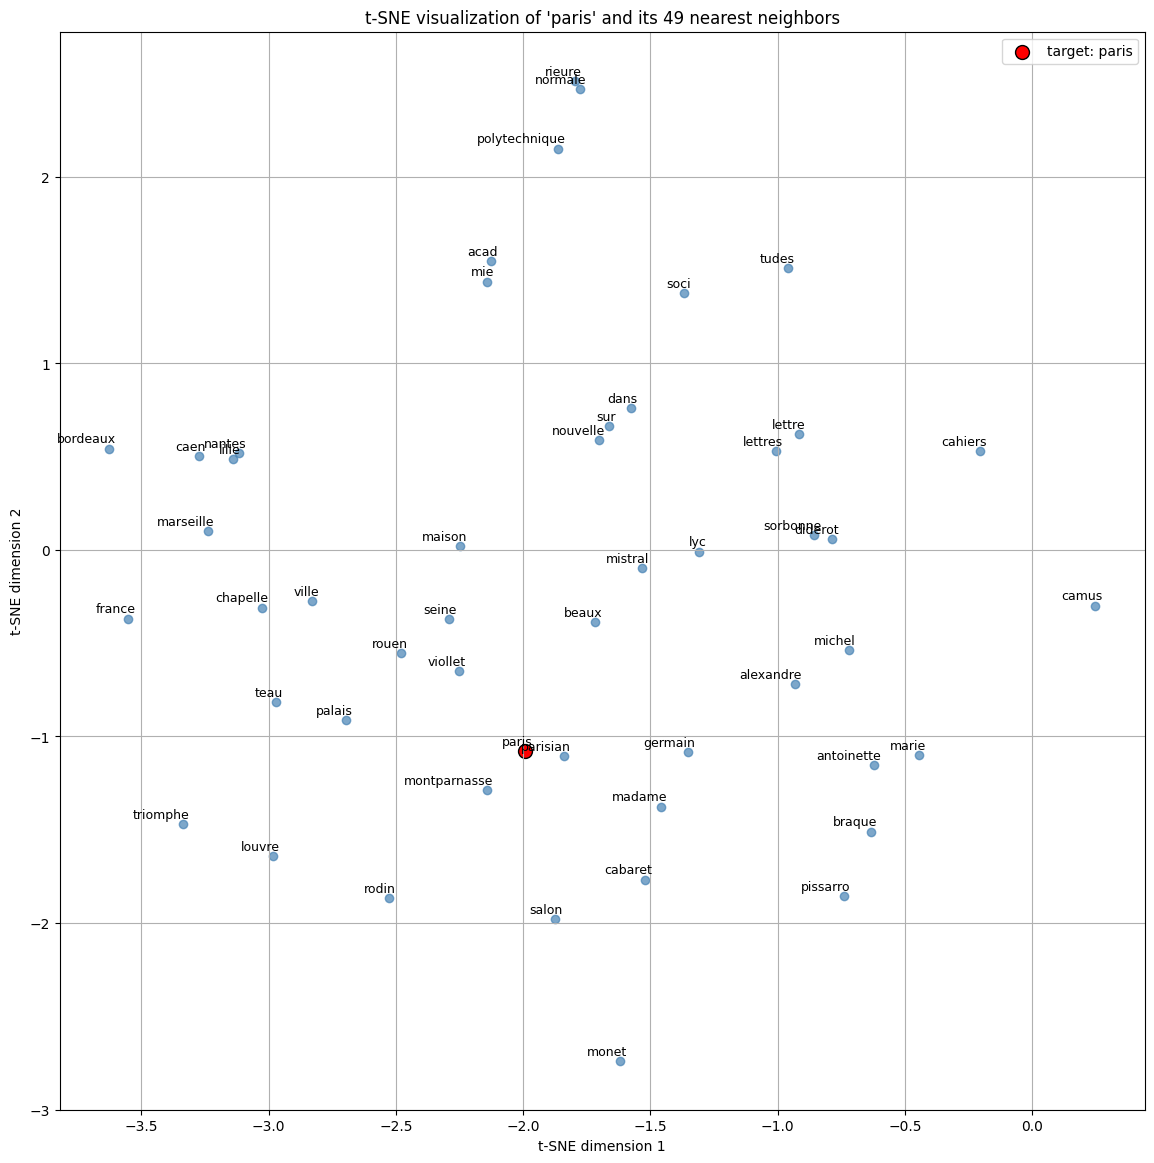

In [61]:
tsne_plot("paris")

Selected words: ['rossetti', 'wandered', 'sister', 'granddaughter', 'beloved', 'heiress', 'courtier', 'sisters', 'paternal', 'stillborn', 'married', 'rightful', 'deathbed', 'heir', 'elder', 'niece', 'sarah', 'daughters', 'brother', 'consort', 'widowed', 'antonia', 'laban', 'aegisthus', 'marry', 'disciple', 'uncle', 'orestes', 'grandchildren', 'concubine', 'confessor', 'remarried', 'beatrice', 'consorts', 'childless', 'daughter', 'grandfather', 'younger', 'grandmother', 'whom', 'fathered', 'devout', 'cousin', 'begotten', 'eldest', 'betrothed', 'wife', 'son', 'mother', 'father']
t-SNE finished.


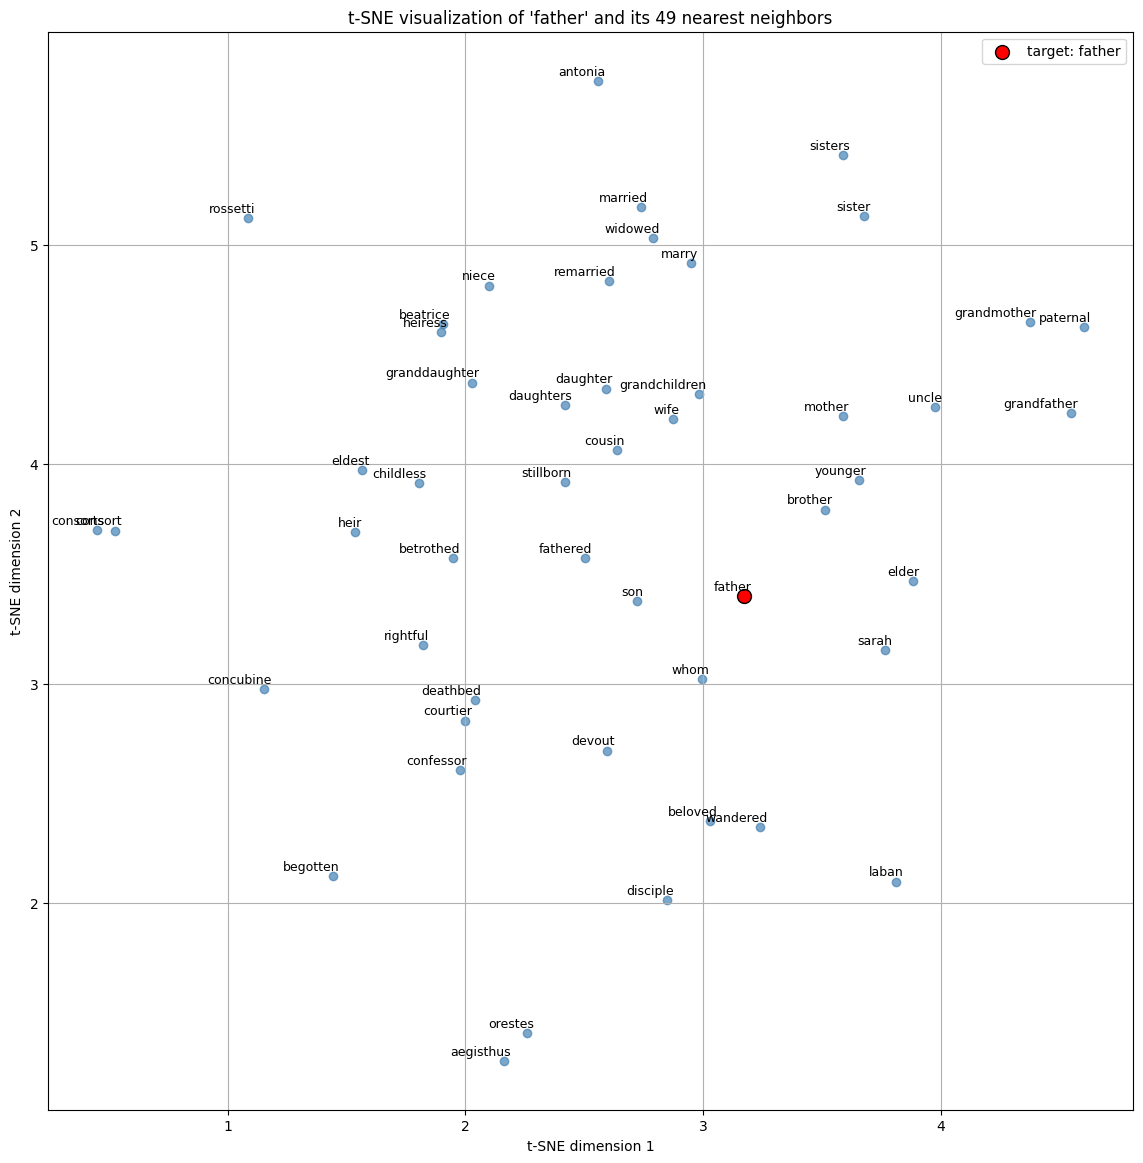

In [62]:
tsne_plot("father")

Selected words: ['kronecker', 'banach', 'lagrange', 'diophantine', 'euclidean', 'bijection', 'homotopy', 'surjective', 'multiplicative', 'isomorphism', 'axioms', 'fermat', 'homomorphism', 'hilbert', 'isomorphisms', 'associativity', 'commutator', 'injective', 'cosets', 'homomorphisms', 'zermelo', 'grothendieck', 'axiomatization', 'isomorphic', 'reals', 'projective', 'riemann', 'algebras', 'dedekind', 'weierstrass', 'inverses', 'endomorphism', 'legendre', 'rationals', 'quaternions', 'groupoid', 'commutativity', 'polynomials', 'theoretic', 'automorphism', 'theorems', 'adic', 'algebraically', 'commutative', 'cohomology', 'algebra', 'abelian', 'automorphisms', 'algebraic', 'galois']
t-SNE finished.


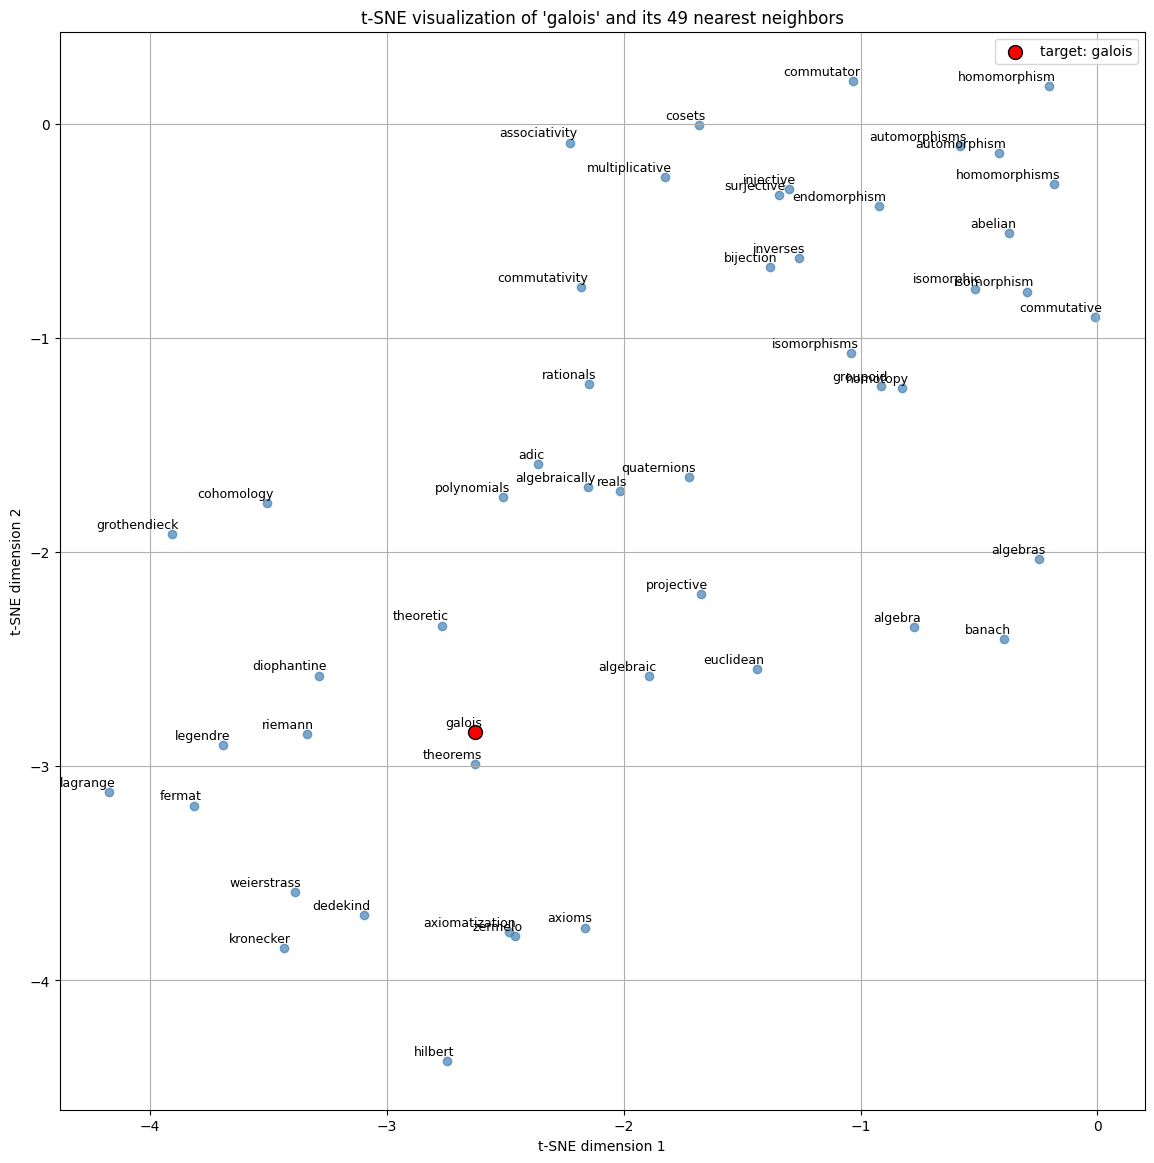

In [63]:
tsne_plot("galois")

We can observe semantically similar words clustered around the target word in all the plots.

## 4.4 Visualizing Learned Analogies using PCA
In a similar vein as the previous section, we now aim to visualize some capital-country analogies.

In [64]:
from sklearn.decomposition import PCA
def analogy_plot(embeddings):
    countries = ["China", "Russia", "Japan", "Turkey", "Poland", "Germany", 
                "France", "Italy", "Greece", "Spain", "Portugal", "India", "Pakistan"]
    capitals  = ["Beijing", "Moscow", "Tokyo", "Ankara", "Warsaw", "Berlin", 
                "Paris", "Rome", "Athens", "Madrid", "Lisbon", "Delhi", "Islamabad"]

    # we first collect the embeddings for all these words.
    all_words = countries + capitals
    all_embeddings = []
    for word in all_words:
        vec = embeddings[word2idx[word.lower()]] # recall our vocab is in lowercase
        all_embeddings.append(vec)

    all_embeddings = np.array(all_embeddings)  # shape: (2 * #countries, embedding_dim)

    # we apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2, random_state=42)
    all_embeddings_2d = pca.fit_transform(all_embeddings)  # shape: (2 * #countries, 2)



    plt.figure(figsize=(8, 6))
    # split countries' points and capitals' points
    n = len(countries)
    country_coords = all_embeddings_2d[:n, :]
    capital_coords = all_embeddings_2d[n:, :]

    # plot countries with red x
    plt.scatter(country_coords[:, 0], country_coords[:, 1], 
                color='red', marker='x', label='Countries')

    # plot capitals with blue o
    plt.scatter(capital_coords[:, 0], capital_coords[:, 1], 
                color='blue', marker='o', label='Capitals')

    # labels and dotted line
    for i, country in enumerate(countries):
        x_c, y_c = country_coords[i]
        plt.annotate(country, (x_c, y_c), 
                    xytext=(5, 5), textcoords="offset points", 
                    color='red', fontsize=9)
        
        x_cap, y_cap = capital_coords[i]
        plt.annotate(capitals[i], (x_cap, y_cap), 
                    xytext=(5, 5), textcoords="offset points", 
                    color='blue', fontsize=9)
        
        # dotted line from the country to its capital
        plt.plot([x_c, x_cap], [y_c, y_cap],
                linestyle='--', color='gray', linewidth=0.8)

    plt.title("Country and Capital Vectors Projected by PCA")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

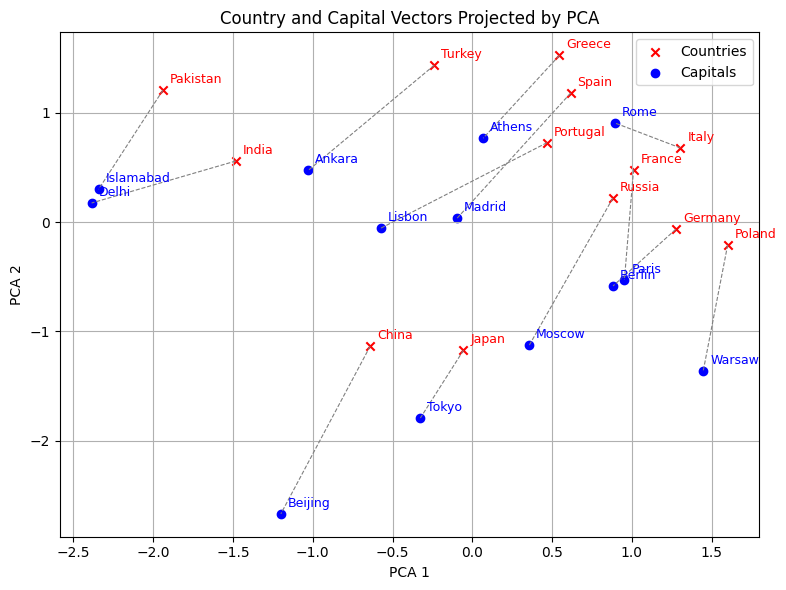

In [65]:
analogy_plot(embeddings=center_embeddings)

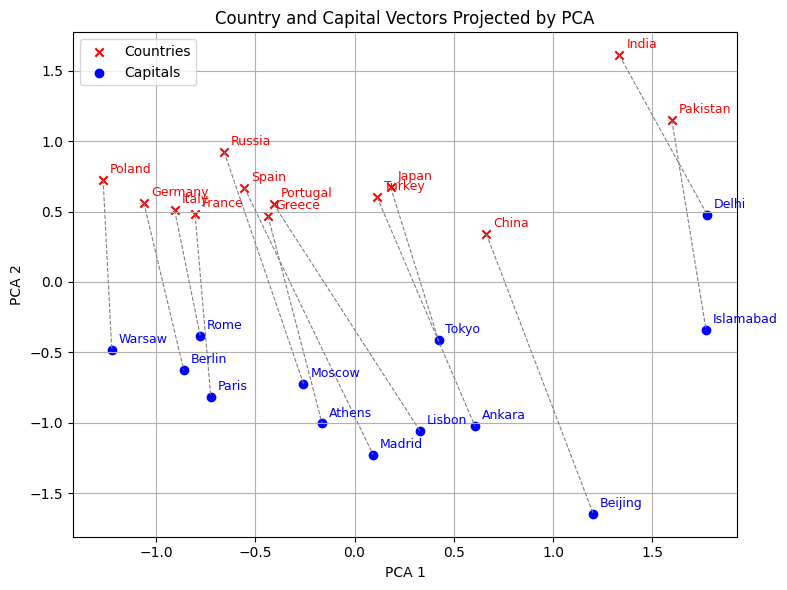

In [66]:
analogy_plot(embeddings=context_embeddings)

As we can observe in both the plots, analogies resembles (almost) parallel lines pointing in the same general direction, except for a few outliers (such as Rome-Italy in the first plot). A striking difference is that context embeddings created much better aligned lines than the center embeddings. This highlights that context embeddings can possibly have comparable performance for certain downstream tasks. That said, the consensus in the literature leans towards center embeddings being better for a wider range of tasks, and dimensionality reduction techniques (like PCA or t-SNE) do not usually perfectly preserve all the relationships present in the original high-dimensional space. So, broad generalization would warrant further quantitative investigation. 

# 5 `gensim` implementation

In this final section, we transition to a highly efficient implementation of skip-gram using `gensim`, an open-source library for unsupervised topic modelling, document indexing, retrieval similarity, and other NLP tasks.

In [77]:
from gensim.models import Word2Vec
import time

start_training = time.time()

# read and preprocess
with open("text8", "rt") as f:
    text = f.read().split()

# convert to list of lists (as required by gensim Word2Vec)
data = [text[i:i+100] for i in range(0, len(text), 100)]

# train Skip-gram
model = Word2Vec(
    sentences=data, 
    vector_size=EMBED_DIM, 
    window=WINDOW_SIZE, 
    min_count=MIN_COUNT, 
    sg=1 # flag for using Skip-gram instead of CBOW
    )

total_training_time = (time.time() - start_training) / 60
print(f"\nTRAINING COMPLETE!")
print(f"Total duration: {total_training_time:.2f} mins")


TRAINING COMPLETE!
Total duration: 2.45 mins


`gensim`'s implementation, owing to its lower level, highly optimized subroutines, trains in < 3 minutes.

In [78]:
accuracy = model.wv.evaluate_word_analogies(datapath("questions-words.txt"))[0]
similarity_score = model.wv.evaluate_word_pairs(datapath("wordsim353.tsv"))[1][0]
print(f"Accuracy on Google's analogy dataset: {accuracy:.4f}")
print(f"Spearman rank correlation with WordSimilarity-353: {similarity_score:.4f}")

Accuracy on Google's analogy dataset: 0.3854
Spearman rank correlation with WordSimilarity-353: 0.7089


In [79]:
gensim_extrinsic_score = (accuracy+similarity_score)/2
print(f"gensim skip-gram's extrinsic score {gensim_extrinsic_score:.4f}")

gensim skip-gram's extrinsic score 0.5472


And, by our own choice of _an_ extrinsic score, defined in Section 3.2, the gensim's implementation outperforms our model by:

In [70]:
print(f"Increase in extrinsic score: {gensim_extrinsic_score-best_extrinsic_score.mean():4f}")

Increase in extrinsic score: 0.066362


Let's do the `king-man+woman` test:

In [80]:
print(model.wv.most_similar(positive=["king", "woman"], negative=["man"])) # expected output: queen

[('queen', 0.5648064613342285), ('daughter', 0.5098333358764648), ('matilda', 0.5041801929473877), ('isabella', 0.5006727576255798), ('consort', 0.49659571051597595), ('childless', 0.47486552596092224), ('valois', 0.4691275358200073), ('heiress', 0.4685763120651245), ('princess', 0.46825656294822693), ('aragon', 0.4673868417739868)]


And, a capital-country analogies example:

In [81]:
print(model.wv.most_similar(positive=["paris", "spain"], negative=["france"])) # expected output: madrid

[('seville', 0.6239478588104248), ('madrid', 0.6083540320396423), ('buenos', 0.5991405844688416), ('almagro', 0.5940200090408325), ('toledo', 0.5827649235725403), ('aires', 0.5803528428077698), ('santiago', 0.5750945210456848), ('las', 0.5651853084564209), ('palermo', 0.5640905499458313), ('barcelona', 0.5616471767425537)]


In [83]:
print(model.wv.most_similar(positive=["paris", "india"], negative=["france"])) # expected output: delhi

[('indian', 0.5448468327522278), ('delhi', 0.5266944766044617), ('bombay', 0.5260063409805298), ('mumbai', 0.5212541222572327), ('calcutta', 0.5024552345275879), ('cairo', 0.49642059206962585), ('punjab', 0.49178528785705566), ('shanghai', 0.4895625412464142), ('kolkata', 0.48680341243743896), ('chennai', 0.4819052517414093)]


Let us recall the `analogy()` results for these examples using the PyTorch model.

In [84]:
analogy("france", "paris", "spain") # expected output: madrid

[('madrid', 0.5487297),
 ('seville', 0.49600995),
 ('enrique', 0.49023026),
 ('rodrigo', 0.46493188),
 ('marrakesh', 0.46446759)]

In [85]:
analogy("france", "paris", "india") # expected output: delhi

[('delhi', 0.50723225),
 ('pune', 0.4870246),
 ('bangalore', 0.48350576),
 ('gujarat', 0.47575718),
 ('calcutta', 0.47168258)]

So, `gensim` learns some analogies, which our PyTorch model couldn't, (such as `king-man+woman=queen`) but loses out on some capital-country analogies.

While our exploration of the skip-gram model primarily focused on PyTorch, the significantly faster training time observed with `gensim` highlights a crucial consideration for practical applications. Its highly optimized implementation allows for remarkably fast training, and that too with comparable extrinsic scores.

We conclude with two takeaways from our exploration of the skip-gram model:

1. Vector representations of words, as learned by the model, effectively capture semantic relationships, placing words with similar meanings close together (in the sense of cosine similarity) in the embedding space.
2. Overheads in higher-level programming languages, even with all the clever heuristics for GPU parallelization, can become significant when compute is paramount. For tasks where training speed is critical, leveraging the efficiency of lower-level languages like C/C++ offers a substantial advantage.

# References

[1] T. Mikolov, K. Chen, G. Corrado, and J. Dean, "Efficient estimation of word representations in vector space," arXiv preprint arXiv:1301.3781, 2013. [Online]. Available: https://arxiv.org/abs/1301.3781  

[2] T. Mikolov, I. Sutskever, K. Chen, G. Corrado, and J. Dean, "Distributed representations of words and phrases and their compositionality," arXiv preprint arXiv:1310.4546, 2013. [Online]. Available: https://arxiv.org/abs/1310.4546  

[3] M. Gutmann and A. Hyvärinen, "Noise-contrastive estimation: A new estimation principle for unnormalized statistical models," in Proc. 13th Int. Conf. Artif. Intell. Statist. (AISTATS), Sardinia, Italy, May 13–15, 2010, vol. 9, pp. 297–304. [Online]. Available: https://proceedings.mlr.press/v9/gutmann10a.html  

[4] A. Mnih and Y. W. Teh, "A Fast and Simple Algorithm for Training Neural Probabilistic Language Models," arXiv preprint arXiv:1206.6426, 2012. 1  [Online]. Available: https://arxiv.org/abs/1206.6426

[5] M. U. Gutmann and A. Hyvärinen, "Noise-Contrastive Estimation of Unnormalized Statistical Models, with Applications to Natural Image Statistics," _Journal of Machine Learning Research_, vol. 13, no. 11, pp. 307–361, 2012. [Online]. Available: http://jmlr.org/papers/v13/gutmann12a.html